## Install the package dependencies before running this notebook

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
# Get the device
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [10]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# # intialize a dataset
city = 'austin' 
split = 'train'

def normalize(trajectories):
    minxy = np.min(trajectories, axis=-1)
    maxxy = np.max(trajectories, axis=-1)
    scale = np.max(maxxy - minxy) / 2.0
    return (trajectories / scale), scale

def unnormalize(trajectories, scale):
    return trajectories * scale


def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         tensor = torch.Tensor(self.feature[item])
#         tensorlabel = torch.Tensor(self.label[item])
#         return tensor.to(device), tensorlabel.to(device)

        data = np.concatenate((self.inputs[idx], self.outputs[idx]))
            
        if self.transform:
            data = self.transform(data)

        return torch.Tensor(data).to(device)
    

# process data
inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
all_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    all_in_1.append(togetherData)



# every sentence has length 50, with the 51st character as target value
# set range step higher if overfit     
# if dataArr is with velocity, remove for y labels
def create_set(dataArr, normalization=True):
    normArr = dataArr
    scale = 0
    set_x = []
    set_y = []
    if(normalization):
        normArr, scale = normalize(dataArr)
    for i, elem in enumerate(normArr):
        for j in range(0, 60):
            set_x.append(elem[j:j+50])
            set_y.append(elem[j+50])
    return set_x, set_y, scale

class mydataset(Dataset):
    def __init__(self, x, y):
        
        self.feature = x
        self.label = y
        
    def __getitem__(self, item):
        
        tensor = torch.Tensor(self.feature[item])
        tensorlabel = torch.Tensor(self.label[item])
        return tensor.to(device), tensorlabel.to(device)
    
    def __len__(self):
        return len(self.feature)
    
# input: n*110*2 paths
# output: n*110*4 paths with dim2 = [x,y,Vx,Vy], where Vx, Vy are velocity with length/.1s as unit
def addVelocity(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
        pathWV.append(np.concatenate((path[0], path[1] - path[0])))
        for coord in range(1, len(path)):
            vel = path[coord] - path[coord-1]
            coordWV = np.concatenate((path[coord], vel))
            pathWV.append(coordWV)
        dataWV.append(pathWV)
    return dataWV
            

# tempNorm, tempScale = normalize(all_in_1)
# tempunNorm = unnormalize(tempNorm, tempScale)
# print ("tempNorm", tempNorm)
# print ("unNorm", tempunNorm)
# print ("original", np.array(all_in_1))


    
all_in_1_WV = addVelocity(all_in_1)
training_set_x, training_set_y, scale = create_set(all_in_1_WV, normalization=False)
train_dataset = mydataset(training_set_x, training_set_y)

Current Velocity is not normalized, which adds weight to training

In [11]:
# print (np.array(training_set_y).shape)

In [12]:
inputs, outputs = get_city_trajectories(city=city, split='val', normalized=False)
val_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    val_in_1.append(togetherData)

# every sentence has length 40, with the 41st character as target value
# set range step higher if overfit

# random subsampling from val_set to make faster validation
numValPath = 500
val_in_1_WV = addVelocity(val_in_1)
val_index = np.random.choice(len(val_in_1_WV), numValPath, replace=False)
val_set_x, val_set_y, scale_val = create_set(np.array(val_in_1_WV)[val_index])
val_dataset = mydataset(val_set_x, val_set_y)        
print (np.array(val_set_y).shape)

(30000, 4)


In [13]:
# val_dataset = ArgoverseDataset(city = city, split = 'val')

In [14]:
# len(val_dataset)
# print(len(val_dataset))


# print (np.array(all_in_1).shape)

Changed batch size from 64 to 60 -> a complete path
Used normalization to get rid of distrubacnes of coordiantes
Considering: angle, velocity only as features.

## Create a DataLoader class for training

In [16]:
batch_sz = 5  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True)
test_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle = True)

In [17]:
from torch import nn, optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        #Hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.layer_dim = layer_dim
        
        #imput dim
        self.input_dim = input_dim
        
        
        #Building your LSTM
        #batch_first=True causes input/output tensors to be of shape
        #(batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        #Readout layer
        self.fc = nn.Linear (hidden_dim, output_dim)
        
#         self.Softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        #Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
#         print("h0 dtype: ", h0.dtype)
        
        #Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        
        #Output channel
#         output, (hn, cn) = self.lstm(x, (h0, c0))
        output, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        hn = hn.view(-1,self.hidden_dim)
        out = self.fc(hn)
        
#         out = output.view(-1,self.hidden_dim)
#         out = self.fc(out)

#         output, state = self.lstm(x, prev_state)
#         output = output.type(torch.LongTensor)
#         output = output.to(device)
#         out = self.Softmax(out)
        
        return out
    
#     def init_state(self, sequence_length):
#         return (torch.zeros(self.layer_dim, sequence_length, self.input_dim),
#                 torch.zeros(self.layer_dim, sequence_length, self.input_dim))

In [19]:
# epochs
epochs = 20
input_dim = 4
hidden_dim = 150
layer_count = 1
output_dim = 4

lstm = LSTMModel(input_dim, hidden_dim, layer_count, output_dim).to(device)
print(device, "\n", lstm)

cuda:0 
 LSTMModel(
  (lstm): LSTM(4, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=4, bias=True)
)


In [53]:
# pred = Pred()
# opt = optim.Adam(lstm.parameters(), lr=1e-3)

In [54]:
# define hyper parameters
learning_rate = 0.0005
# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# visualize the inner data shape
for name, param in lstm.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)

lstm.weight_ih_l0 torch.Size([600, 4])
lstm.weight_hh_l0 torch.Size([600, 150])
lstm.bias_ih_l0 torch.Size([600])
lstm.bias_hh_l0 torch.Size([600])
fc.weight torch.Size([2, 150])
fc.bias torch.Size([2])


In [79]:
import time
import matplotlib.pyplot as plt
lossArr = []
# tranining function
def train(dataloader, model, patience=3):
#     enable gradients
    model.train()
    print("Begin time: ", time.ctime())
    last_loss = 0
    patience= patience
    for epoch in range(epochs):
#         sh, sc = model.init_state(sequence_length)
        totalLoss = 0
        for batch , (x,y) in enumerate(dataloader):
            optimizer.zero_grad()
    #         print("shape of x: ", x.shape)
            pred = model(x)
#             print(pred)
            trainLoss = loss(pred, y)
            totalLoss += trainLoss.item()
#             print(trainLoss)
#             sh = sh.detach()
#             sc = sc.detach()
            trainLoss.backward()
            optimizer.step()
            if (batch % 20000 == 0):
                print("Time: ", time.ctime() , "batch: ", batch, "loss: ", totalLoss)
        lossArr.append(totalLoss)
        print("Time: ", time.ctime() , "epoch: ", epoch, "loss: ", totalLoss)
        #        early stopping
#         TODO: change this into validation set! make a smaller validation set
        if (last_loss < totalLoss and last_loss != 0):
            print("EarlyStopping remain patience: ", patience)
            if (patience <= 0):
                print ("Early Stopped")
                return
            patience -= 1
        last_loss = totalLoss

In [67]:
train(train_loader, lstm)

Begin time:  Thu May 26 03:27:58 2022
Time:  Thu May 26 03:27:58 2022 batch:  0 loss:  1.5564373825327493e-05
Time:  Thu May 26 03:29:18 2022 batch:  20000 loss:  1.1493562495045317
Time:  Thu May 26 03:30:35 2022 batch:  40000 loss:  2.0584551931853956
Time:  Thu May 26 03:31:45 2022 batch:  60000 loss:  2.7875986017015046
Time:  Thu May 26 03:32:57 2022 batch:  80000 loss:  3.4683670297109783
Time:  Thu May 26 03:34:11 2022 batch:  100000 loss:  4.024495722311246
Time:  Thu May 26 03:35:32 2022 batch:  120000 loss:  4.514120538220255
Time:  Thu May 26 03:36:44 2022 batch:  140000 loss:  4.99233716255585
Time:  Thu May 26 03:37:59 2022 batch:  160000 loss:  5.3967822891218615
Time:  Thu May 26 03:39:13 2022 batch:  180000 loss:  5.78959033090773
Time:  Thu May 26 03:40:23 2022 batch:  200000 loss:  6.128169597496248
Time:  Thu May 26 03:41:38 2022 batch:  220000 loss:  6.498278759922766
Time:  Thu May 26 03:42:53 2022 batch:  240000 loss:  6.898848493038593
Time:  Thu May 26 03:44:09 

Time:  Thu May 26 05:36:39 2022 batch:  80000 loss:  0.39157667307837213
Time:  Thu May 26 05:37:51 2022 batch:  100000 loss:  0.4794238616413253
Time:  Thu May 26 05:39:01 2022 batch:  120000 loss:  0.5844354866367878
Time:  Thu May 26 05:40:13 2022 batch:  140000 loss:  0.6966609847687016
Time:  Thu May 26 05:41:24 2022 batch:  160000 loss:  0.7807206084456664
Time:  Thu May 26 05:42:35 2022 batch:  180000 loss:  0.8680885499255833
Time:  Thu May 26 05:43:44 2022 batch:  200000 loss:  0.9658847479656218
Time:  Thu May 26 05:44:56 2022 batch:  220000 loss:  1.0527206985797906
Time:  Thu May 26 05:46:10 2022 batch:  240000 loss:  1.1609333884794693
Time:  Thu May 26 05:47:23 2022 batch:  260000 loss:  1.2695164035694835
Time:  Thu May 26 05:48:39 2022 batch:  280000 loss:  1.3376308502129906
Time:  Thu May 26 05:49:54 2022 batch:  300000 loss:  1.4341312092918324
Time:  Thu May 26 05:51:05 2022 batch:  320000 loss:  1.5252875663385248
Time:  Thu May 26 05:52:15 2022 batch:  340000 loss

Time:  Thu May 26 07:42:24 2022 batch:  120000 loss:  4.011900441206608
Time:  Thu May 26 07:43:37 2022 batch:  140000 loss:  4.121223814983946
Time:  Thu May 26 07:44:49 2022 batch:  160000 loss:  4.194912864439308
Time:  Thu May 26 07:46:00 2022 batch:  180000 loss:  4.2663843810401545
Time:  Thu May 26 07:47:09 2022 batch:  200000 loss:  4.358726080854454
Time:  Thu May 26 07:48:20 2022 batch:  220000 loss:  4.42183580977112
Time:  Thu May 26 07:49:32 2022 batch:  240000 loss:  4.505119081675181
Time:  Thu May 26 07:50:43 2022 batch:  260000 loss:  4.590705910361145
Time:  Thu May 26 07:51:58 2022 batch:  280000 loss:  4.643297848885921
Time:  Thu May 26 07:53:14 2022 batch:  300000 loss:  4.7130981869825606
Time:  Thu May 26 07:54:27 2022 batch:  320000 loss:  4.799700204107966
Time:  Thu May 26 07:55:39 2022 batch:  340000 loss:  4.862883128072113
Time:  Thu May 26 07:56:51 2022 batch:  360000 loss:  4.945360780350709
Time:  Thu May 26 07:58:03 2022 batch:  380000 loss:  5.0044287

In [13]:
# save the trained model
# torch.save(lstm.state_dict(), "trained_lstm" + "_lr%s_epoch%d_hd%d" % (str(learning_rate), epochs, hidden_dim))
# numpy.save("./lossArr/" + "trained_lstm" + "_lr%s_epoch%d_hd%d" % (str(learning_rate), epochs, hidden_dim), lossArr)
# load the trained model
# lstm.load_state_dict(torch.load("trained_lstm_lr0.0005_epoch50_hd150"))


<All keys matched successfully>

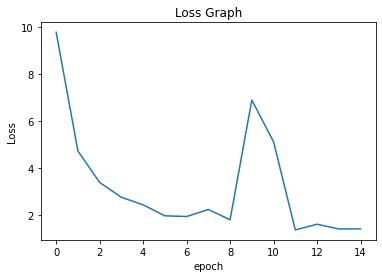

In [68]:
plt.plot(lossArr)
plt.title('Loss Graph')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [69]:
def predict(seed, model):
    model.eval()
    prepseed = torch.Tensor(seed).to(device)
    res = model(seed.to(device))
    res = res.cpu().detach().numpy()
#     print (res.shape)
    return res

def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    testLoss, correct = 0,0
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader):
            pred = model(x)
            testLoss += loss(pred, y).item()
    testLoss /= size
    print(f"Test Error: \n Avg loss: {testLoss:>8f} \n")

test(test_loader, lstm)

Test Error: 
 Avg loss: 0.000002 



[[-3.541725 -8.866736]]


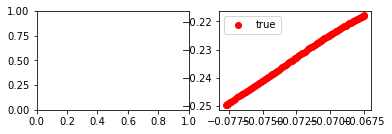

In [92]:
# # gives a 50 timestep data and generates the future 60 timesteps
# # def genPath(seed, model):
# #     model.eval()
    
# #     resAll = seed
# #     for i in range(60):
# #         resAll = np.append (resAll, predict(torch.unsqueeze(torch.FloatTensor(resAll[i:i+50]), 0), model))
# #     return resAll[51:]

def genPath(seed, model):
    path_w_seed = seed
#     for i in range(target_length - len(seed)):
    for i in range(60):
#         print (len(torch.Tensor(path_w_seed[i:i + 50])))
#         print(predict(torch.Tensor(path_w_seed[i:i + 50]).unsqueeze(1), model).shape)
        path_w_seed = np.concatenate((path_w_seed, predict(torch.Tensor(path_w_seed[i:i + 50]).unsqueeze(0), model)))
    return path_w_seed


# print (np.array(pathPred).shape)

# parse a path and separate the x and y coordinates
def parsePath(path):
    tempX = []
    tempY = []
    for elem in path:
        tempX.append(elem[0])
        tempY.append(elem[1])
    return tempX, tempY


# normalized, scale_2 = normalize(all_in_1)
# 
# pathPred = genPath((all_in_1_WV[1800])[0:50], lstm)
print (predict(torch.Tensor((all_in_1_WV[1800])[0:50]).unsqueeze(0), lstm))
# print ("true: ", normalized[1800][51])
# scatX, scatY = parsePath(pathPred)
# plt.scatter(scatX, scatY)
trueX, trueY = parsePath(normalized[1800])
# plt.scatter(trueX, trueY)

# plt.show

# print (torch.Tensor(all_in_1[0][0:50]).unsqueeze(1))
# predict(torch.FloatTensor(all_in_1[0][0:50]), lstm)

# print(scatX[49:])
# print(trueX[49:])

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# ax1.scatter(scatX, scatY, c='b', marker="o", label='scat')
ax2.scatter(trueX,trueY, c='r', marker="o", label='true')
plt.legend(loc='upper left');

# ax = plt.gca()
# ax.scatter(scatX, scatY, color="b")
# ax.scatter(trueX, trueY, color="r")

## Sample a batch of data and visualize 

In [45]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        
# show_sample_batch(sample_batch)


        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape, out.shape)
#     show_sample_batch(sample_batch)
    break
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """

torch.Size([60, 50, 4]) torch.Size([60, 2])


In [ ]:
import matplotlib.pyplot as plt

# for elem in y:
y_show = y[2]
    x_res = []
    y_res = []
    for i in range(0,120,2):
        x_res.append(y_show[i])
        y_res.append(y_show[i+1])
    plt.scatter(x_res, y_res)
    plt.show
    break